## 1. 국민건강보험공단 진료내역정보 데이터 확인

In [1]:
# 사용되는 라이브러리 임포트

# 기초 라이브러리
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib.pyplot as plt
plt.rc('font', family='NanumSquare')
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.ticker as mticker
from matplotlib.table import Table
import seaborn as sns

# 분석/통계용 라이브러리
from scipy.stats import chi2_contingency, f_oneway, kruskal
from collections import Counter
from math import log2

# 모델 학습/머신러닝 라이브러리
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import joblib

### a. 파일 읽기

In [2]:
file_path = './국민건강보험공단_진료내역정보_20231231.CSV'
nhis_clinic_info_df = pd.read_csv(file_path, encoding='cp949')
del(file_path)

### b. 기초분석

In [4]:
len(nhis_clinic_info_df)

13831382

In [5]:
nhis_clinic_info_df.head()

,기준년도,가입자일련번호,진료내역일련번호,성별코드,연령대코드,시도코드,요양개시일자,서식코드,진료과목코드,주상병코드,부상병코드,요양일수,입내원일수,심결가산율,심결요양급여비용총액,심결본인부담금,심결보험자부담금,총처방일수
0,2023,416815,2667446,2,14,26,2023-02-02,3,1,J209,J304,1,1,0.15,12380,1500,10880,4
1,2023,607165,2669619,1,14,28,2023-02-06,3,1,J209,J304,1,1,0.15,12380,1500,10880,5
2,2023,301410,2680722,1,14,41,2023-02-02,3,1,J209,J304,1,1,0.15,12380,1500,10880,3
3,2023,193953,2682490,2,14,26,2023-02-28,3,1,J209,J304,1,1,0.15,12380,1500,10880,3
4,2023,859131,2684667,1,14,41,2023-02-15,3,1,J209,J304,1,1,0.15,12380,1500,10880,2


In [6]:
# 칼럼별 데이터타입 확인
nhis_clinic_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13831382 entries, 0 to 13831381
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   기준년도        int64  
 1   가입자일련번호     int64  
 2   진료내역일련번호    int64  
 3   성별코드        int64  
 4   연령대코드       int64  
 5   시도코드        int64  
 6   요양개시일자      object 
 7   서식코드        int64  
 8   진료과목코드      int64  
 9   주상병코드       object 
 10  부상병코드       object 
 11  요양일수        int64  
 12  입내원일수       int64  
 13  심결가산율       float64
 14  심결요양급여비용총액  int64  
 15  심결본인부담금     int64  
 16  심결보험자부담금    int64  
 17  총처방일수       int64  
dtypes: float64(1), int64(14), object(3)
memory usage: 1.9+ GB


In [7]:
# 통계분석이 가능한 칼럼들에 대해 describ
nhis_clinic_info_df.select_dtypes(include=[np.number]).describe()

,기준년도,가입자일련번호,진료내역일련번호,성별코드,연령대코드,시도코드,서식코드,진료과목코드,요양일수,입내원일수,심결가산율,심결요양급여비용총액,심결본인부담금,심결보험자부담금,총처방일수
count,13831382.0,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07,1.383138e+07
mean,2023.0,4.999785e+05,6.915692e+06,1.558359e+00,1.030193e+01,3.372709e+01,2.990736e+00,7.018116e+00,1.168946e+00,1.945105e+00,1.710434e-01,1.029013e+05,2.277036e+04,7.986041e+04,1.298902e+01
std,0.0,2.884983e+05,3.992776e+06,4.965825e-01,4.942965e+00,1.269704e+01,2.804245e-01,6.179031e+00,1.930209e+00,5.969585e+00,4.386271e-02,7.832299e+05,1.104770e+05,6.975426e+05,2.650049e+01
min,2023.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2023.0,2.501550e+05,3.457846e+06,1.000000e+00,7.000000e+00,2.700000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e-01,1.492000e+04,3.700000e+03,1.088000e+04,0.000000e+00
50%,2023.0,4.999490e+05,6.915692e+06,2.000000e+00,1.100000e+01,4.100000e+01,3.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,1.500000e-01,1.969000e+04,5.400000e+03,1.511000e+04,4.000000e+00
75%,2023.0,7.493560e+05,1.037354e+07,2.000000e+00,1.400000e+01,4.300000e+01,3.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.500000e-01,4.504000e+04,1.330000e+04,3.112000e+04,7.000000e+00
max,2023.0,1.000000e+06,1.383138e+07,2.000000e+00,1.800000e+01,4.900000e+01,8.000000e+00,8.600000e+01,1.820000e+02,9.000000e+02,3.000000e-01,3.864448e+08,3.755560e+07,3.668130e+08,9.600000e+02


In [8]:
# 특정 칼럼의 고유값 개수와 고유값 확인

print(f"가입자일련번호의 고유값 개수 : {nhis_clinic_info_df['가입자일련번호'].nunique()}") 
# 총 100만명의 가입자에 대해 있는 데이터

print(f"진료내역일련번호의 고유값 개수 : {nhis_clinic_info_df['진료내역일련번호'].nunique()}") 
# 전체 데이터 갯수와 같음

print(f"연령대코드의 고유값 개수 : {nhis_clinic_info_df['연령대코드'].nunique()}")
# 1~18까지, 나이를 5세 단위로 그룹화

print(f"시도코드의 고유값 개수 : {nhis_clinic_info_df['시도코드'].nunique()}")
# 총 17개, 11 서울특별시 / 42 강원도 / 26 부산광역시 / 43 충청북도 / 27 대구광역시 / 44 충청남도 / 28 인천광역시 / 45 전라북도 / 29 광주광역시
# 46 전라남도 / 30 대전광역시 / 47 경상북도 / 31 울산광역시 / 48 경상남도 / 36 세종특별자치시 / 49 제주특별자치도 / 41 경기도

print(f"서식코드의 고유값 개수 : {nhis_clinic_info_df['서식코드'].nunique()}")
print(f"서식코드의 고유값 : {nhis_clinic_info_df['서식코드'].unique()}")
print(f"서식코드 고유값 개수별 열 개수 : \n{nhis_clinic_info_df['서식코드'].value_counts()}", end='\n\n')
# 3 의과 외래 / 2 의과 입원 / 8 보건기관 외래

print(f"진료과목코드의 고유값 개수 : {nhis_clinic_info_df['진료과목코드'].nunique()}")
print(f"진료과목코드의 고유값 : {sorted(nhis_clinic_info_df['진료과목코드'].unique().tolist())}", end='\n\n')

print(f"주상병코드의 고유값 개수 : {nhis_clinic_info_df['주상병코드'].nunique()}")
print(f"부상병코드의 고유값 개수 : {nhis_clinic_info_df['부상병코드'].nunique()}")

가입자일련번호의 고유값 개수 : 1000000
진료내역일련번호의 고유값 개수 : 13831382
연령대코드의 고유값 개수 : 18
시도코드의 고유값 개수 : 17
서식코드의 고유값 개수 : 3
서식코드의 고유값 : [3 2 8]
서식코드 고유값 개수별 열 개수 : 
서식코드
3    13511100
2      288258
8       32024
Name: count, dtype: int64

진료과목코드의 고유값 개수 : 35
진료과목코드의 고유값 : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 50, 51, 54, 55, 80, 83, 85, 86]

주상병코드의 고유값 개수 : 8966
부상병코드의 고유값 개수 : 9247


### c. 데이터 정제

#### 상병코드 소숫점 추가

In [7]:
def format_disease_code(code):
  """
    주상병코드와 부상병코드의 숫자가 3자리거나 4자리일 경우 {알파벳}{앞 두 숫자}.{남은숫자} 형식으로 변환합니다.
    예시: A123 -> A12.3, B45 -> B45 (변환 없음)
    """
  if pd.isna(code) or not isinstance(code, str):
    return code

  # 첫 글자가 알파벳인지 확인
  if len(code) > 0 and code[0].isalpha():
    alpha_part = code[0]
    numeric_part = code[1:]

    # 숫자로만 이루어져 있는지 확인
    if numeric_part.isdigit():
      # 숫자가 3자리 또는 4자리인지 확인
      if len(numeric_part) == 3:
        return f"{alpha_part}{numeric_part[:2]}.{numeric_part[2]}"
      elif len(numeric_part) == 4:
        return f"{alpha_part}{numeric_part[:2]}.{numeric_part[2:]}"
      else:
        return code # 3자리, 4자리 숫자 아니면 변환 없음
    else:
      return code # 숫자 부분이 아니면 변환 없음
  else:
    return code # 첫 글자가 알파벳 아니면 변환 없음

# 주상병코드와 부상병코드 컬럼에 함수 적용
nhis_clinic_info_df['주상병코드'] = nhis_clinic_info_df['주상병코드'].apply(format_disease_code)
# 부상병코드 컬럼이 있다면 해당 컬럼에도 적용
if '부상병코드' in nhis_clinic_info_df.columns:
    nhis_clinic_info_df['부상병코드'] = nhis_clinic_info_df['부상병코드'].apply(format_disease_code)
# 변환된 주상병코드와 부상병코드의 고유값 개수 확인
print(f"변환된 주상병코드의 고유값 개수: {nhis_clinic_info_df['주상병코드'].nunique()}")
print(f"변환된 부상병코드의 고유값 개수: {nhis_clinic_info_df['부상병코드'].nunique()}")
# 고유값 개수는 그대로임.

변환된 주상병코드의 고유값 개수: 8966
변환된 부상병코드의 고유값 개수: 9247


#### 결측치 확인

In [8]:
# 단순 결측치 (데이터 없음) 확인
print(nhis_clinic_info_df.isnull().all())

기준년도          False
가입자일련번호       False
진료내역일련번호      False
성별코드          False
연령대코드         False
시도코드          False
요양개시일자        False
서식코드          False
진료과목코드        False
주상병코드         False
부상병코드         False
요양일수          False
입내원일수         False
심결가산율         False
심결요양급여비용총액    False
심결본인부담금       False
심결보험자부담금      False
총처방일수         False
dtype: bool


#### 데이터 특성에 따른 형변환

In [9]:
# 1. 성별코드: 1(남성), 2(여성) → 0(남성), 1(여성)
nhis_clinic_info_df['성별코드_cat'] = pd.Categorical(nhis_clinic_info_df['성별코드'].replace({1: 0, 2: 1}), categories=[0, 1])

# 결과 동일성 확인
assert (nhis_clinic_info_df['성별코드_cat'].astype(int) == nhis_clinic_info_df['성별코드'].replace({1: 0, 2: 1})).all()
nhis_clinic_info_df = nhis_clinic_info_df.drop(columns=['성별코드'])
nhis_clinic_info_df = nhis_clinic_info_df.rename(columns={'성별코드_cat': '성별코드'})

# 2. 연령대코드: 1~18 → 0~17
nhis_clinic_info_df['연령대코드_cat'] = pd.Categorical(nhis_clinic_info_df['연령대코드'] - 1, categories=range(18))
assert (nhis_clinic_info_df['연령대코드_cat'].astype(int) == (nhis_clinic_info_df['연령대코드'] - 1)).all()
nhis_clinic_info_df = nhis_clinic_info_df.drop(columns=['연령대코드'])
nhis_clinic_info_df = nhis_clinic_info_df.rename(columns={'연령대코드_cat': '연령대코드'})

# 3. 시도코드: 17개를 오름차순 0~16
sido_map = {11: 0, 26: 1, 27: 2, 28: 3, 29: 4, 30: 5, 31: 6, 36: 7, 41: 8, 42: 9, 43: 10, 44: 11, 45: 12, 46: 13, 47: 14, 48: 15, 49: 16}
nhis_clinic_info_df['시도코드_cat'] = pd.Categorical(nhis_clinic_info_df['시도코드'].replace(sido_map), categories=range(17))
assert (nhis_clinic_info_df['시도코드_cat'].astype(int) == nhis_clinic_info_df['시도코드'].replace(sido_map)).all()
nhis_clinic_info_df = nhis_clinic_info_df.drop(columns=['시도코드'])
nhis_clinic_info_df = nhis_clinic_info_df.rename(columns={'시도코드_cat': '시도코드'})
del(sido_map)

# 4. 서식코드: 3(의과 외래), 2(의과 입원), 8(보건기관 외래) → 0,1,2
nhis_clinic_info_df['서식코드_cat'] = pd.Categorical(nhis_clinic_info_df['서식코드'].replace({3: 0, 2: 1, 8: 2}), categories=[0, 1, 2])
assert (nhis_clinic_info_df['서식코드_cat'].astype(int) == nhis_clinic_info_df['서식코드'].replace({3: 0, 2: 1, 8: 2})).all()
nhis_clinic_info_df = nhis_clinic_info_df.drop(columns=['서식코드'])
nhis_clinic_info_df = nhis_clinic_info_df.rename(columns={'서식코드_cat': '서식코드'})

# 5. 진료과목코드: 0~26 그대로, 50~59→27~36, 80~88→37~45
def map_subject_code(x):
    if 0 <= x <= 26:
        return x
    elif 50 <= x <= 59:
        return x - 23
    elif 80 <= x <= 88:
        return x - 43
    else:
        return -1  # 예외값

mapped = nhis_clinic_info_df['진료과목코드'].apply(map_subject_code)
nhis_clinic_info_df['진료과목코드_cat'] = pd.Categorical(mapped, categories=range(46))
assert (nhis_clinic_info_df['진료과목코드_cat'].astype(int) == mapped).all()
nhis_clinic_info_df = nhis_clinic_info_df.drop(columns=['진료과목코드'])
nhis_clinic_info_df = nhis_clinic_info_df.rename(columns={'진료과목코드_cat': '진료과목코드'})

del mapped

In [10]:
# 6. 주상병코드와 부상병코드의 경우, 고유값 개수가 8966 / 9247 개로 많기 때문에 상위 3자리를 묶어서 분석
def extract_top_three_chars(code):
    """
    주상병코드와 부상병코드의 상위 3자리를 추출합니다.
    예시: A12.3 -> A12, / B45 -> B45, F_ -> F_ (변환 없음)
    """
    if pd.isna(code) or not isinstance(code, str):
        return code
    return code[:3]  # 상위 3자리만 추출

nhis_clinic_info_df['주상병코드_상위3자리'] = nhis_clinic_info_df['주상병코드'].apply(extract_top_three_chars)
nhis_clinic_info_df['부상병코드_상위3자리'] = nhis_clinic_info_df['부상병코드'].apply(extract_top_three_chars)
print(f"주상병코드_상위3자리의 고유값 개수: {nhis_clinic_info_df['주상병코드_상위3자리'].nunique()}")
print(f"부상병코드_상위3자리의 고유값 개수: {nhis_clinic_info_df['부상병코드_상위3자리'].nunique()}")

주상병코드_상위3자리의 고유값 개수: 1275
부상병코드_상위3자리의 고유값 개수: 1426


In [11]:
# 7. 묶인 주상병코드와 부상병코드를 범주형 변수로 변환, 기존 주상병코드와 부상병코드 칼럼 삭제
nhis_clinic_info_df['주상병코드_상위3자리'] = pd.Categorical(nhis_clinic_info_df['주상병코드_상위3자리'])
nhis_clinic_info_df['부상병코드_상위3자리'] = pd.Categorical(nhis_clinic_info_df['부상병코드_상위3자리'])
nhis_clinic_info_df = nhis_clinic_info_df.drop(columns=['주상병코드', '부상병코드'])
# 칼럼명 변경
nhis_clinic_info_df = nhis_clinic_info_df.rename(columns={
    '주상병코드_상위3자리': '주상병코드',
    '부상병코드_상위3자리': '부상병코드'
})

# 8. 요양개시일자 컬럼을 datetime 형식으로 변환
nhis_clinic_info_df['요양개시일자'] = pd.to_datetime(nhis_clinic_info_df['요양개시일자'])

In [12]:
nhis_clinic_info_df

,기준년도,가입자일련번호,진료내역일련번호,요양개시일자,요양일수,입내원일수,심결가산율,심결요양급여비용총액,심결본인부담금,심결보험자부담금,총처방일수,성별코드,연령대코드,시도코드,서식코드,진료과목코드,주상병코드,부상병코드
0,2023,416815,2667446,2023-02-02,1,1,0.15,12380,1500,10880,4,1,13,1,0,1,J20,J30
1,2023,607165,2669619,2023-02-06,1,1,0.15,12380,1500,10880,5,0,13,3,0,1,J20,J30
2,2023,301410,2680722,2023-02-02,1,1,0.15,12380,1500,10880,3,0,13,8,0,1,J20,J30
3,2023,193953,2682490,2023-02-28,1,1,0.15,12380,1500,10880,3,1,13,1,0,1,J20,J30
4,2023,859131,2684667,2023-02-15,1,1,0.15,12380,1500,10880,2,0,13,8,0,1,J20,J30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13831377,2023,876501,701658,2023-03-05,1,6,0.30,1116320,55810,1060510,0,0,16,14,1,15,C67,Z11
13831378,2023,876501,701697,2023-03-05,7,14,0.25,2848300,185610,2662690,0,0,16,14,1,15,Z51,C67
13831379,2023,874374,707259,2023-03-05,3,6,0.20,1673920,82920,1591000,0,1,6,0,1,10,O_,O_
13831380,2023,607835,741618,2023-03-05,7,7,0.20,703400,5720,697680,0,1,0,0,1,11,Z_,P59


In [13]:
nhis_clinic_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13831382 entries, 0 to 13831381
Data columns (total 18 columns):
 #   Column      Dtype         
---  ------      -----         
 0   기준년도        int64         
 1   가입자일련번호     int64         
 2   진료내역일련번호    int64         
 3   요양개시일자      datetime64[ns]
 4   요양일수        int64         
 5   입내원일수       int64         
 6   심결가산율       float64       
 7   심결요양급여비용총액  int64         
 8   심결본인부담금     int64         
 9   심결보험자부담금    int64         
 10  총처방일수       int64         
 11  성별코드        category      
 12  연령대코드       category      
 13  시도코드        category      
 14  서식코드        category      
 15  진료과목코드      category      
 16  주상병코드       category      
 17  부상병코드       category      
dtypes: category(7), datetime64[ns](1), float64(1), int64(9)
memory usage: 1.2 GB


## 2. "심결요양급여비용총액" 예측 모델링 전과정

### a. 칼럼별 상관분석 진행

#### 수치형 vs 수치형

수치형 변수 칼럼들: ['가입자일련번호', '진료내역일련번호', '요양일수', '입내원일수', '심결가산율', '심결요양급여비용총액', '심결본인부담금', '심결보험자부담금', '총처방일수']


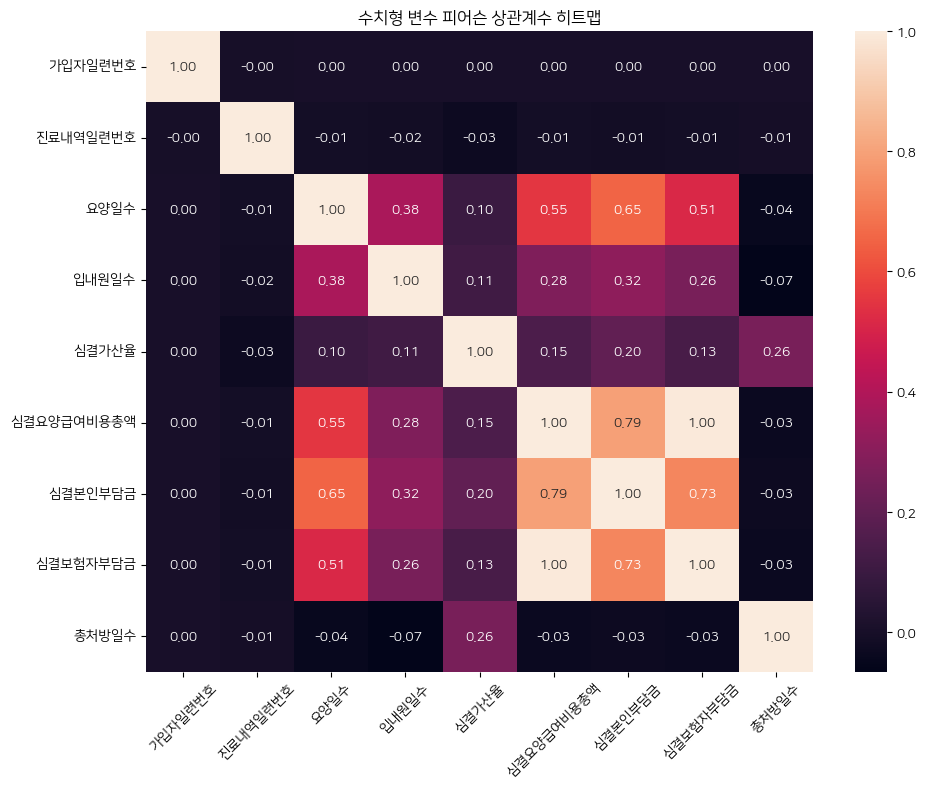

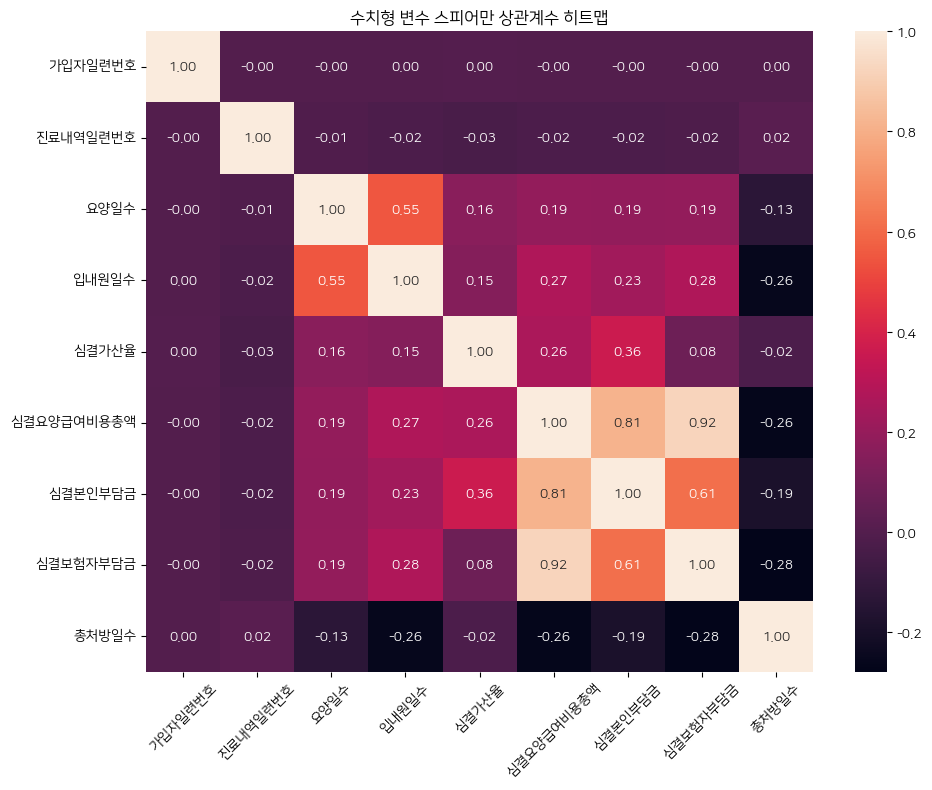

In [14]:
numeric_df = nhis_clinic_info_df.select_dtypes(include=[np.number]).drop(columns=['기준년도'])
# 수치형 변수들의 칼럼 출력
print(f"수치형 변수 칼럼들: {numeric_df.columns.tolist()}")

# 피어슨 상관계수 계산 및 시각화
pearson_correlation_matrix = numeric_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_correlation_matrix, annot=True, fmt=".2f")
plt.title('수치형 변수 피어슨 상관계수 히트맵')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 스피어만 상관계수 계산 및 시각화
spearman_correlation_matrix = numeric_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, fmt=".2f")
plt.title('수치형 변수 스피어만 상관계수 히트맵')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 수치형 변수 간 상관계수 결과 해석

- **피어슨 상관계수(pearson_correlation_matrix)**
  - `요양일수`와 `심결요양급여비용총액`의 상관계수: **0.55**  
    → 요양일수가 많을수록 심결요양급여비용총액이 증가하는 경향이 뚜렷함.
  - `심결본인부담금`, `심결보험자부담금`과 `심결요양급여비용총액`의 상관계수: **0.79, 1.00**  
    → 두 변수 모두 심결요양급여비용총액과 매우 강한 양의 상관관계를 가짐. 특히 보험자부담금이 거의 완벽하게 설명.
  - `입내원일수`, `심결가산율` 등은 심결요양급여비용총액과 약한~중간 정도의 상관관계가 있다. (0.28, 0.15)
  - `총처방일수`는 대부분 변수와 상관관계가 매우 낮으나 심결가산율과는 약한 상관관계가 있다. (0.26)

- **스피어만 상관계수(spearman_correlation_matrix)**
  - 순위 기반 상관계수로, 변수 간 비선형적 관계도 일부 반영.
  - `심결요양급여비용총액`과 `심결보험자부담금`: **0.92**  
    → 순위 기준으로도 거의 완벽한 양의 상관관계.
  - `심결본인부담금`과 `심결요양급여비용총액`: **0.81**

  
  - `요양일수`와 `입내원일수`: **0.55**  
    → 두 변수는 순위 기준으로도 강한 양의 상관관계.
  - `총처방일수`는 여전히 다른 변수와 상관관계가 낮음(음의 상관 포함).

In [15]:
del numeric_df
#del pearson_correlation_matrix, spearman_correlation_matrix 

#### 범주형 vs 범주형

- 귀무가설(H₀): 각 변수는 서로 독립이다.
- 대립가설(H₁): 각 변수는 서로 독립이 아니다(연관성이 있다).

In [ ]:
# 카이제곱 검정을 위한 범주형 변수 선택
categorical_df = nhis_clinic_info_df.select_dtypes(include=['category'])

# 범주형 변수들의 칼럼 출력
print(f"범주형 변수 칼럼들: {categorical_df.columns.tolist()}")

# 카이제곱 검정 결과를 저장할 리스트
chi2_results = []

# 카이제곱 검정 수행
for i, col1 in enumerate(categorical_df.columns):
    for col2 in categorical_df.columns[i+1:]:
        contingency_table = pd.crosstab(categorical_df[col1], categorical_df[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results.append((col1, col2, chi2, p))


범주형 변수 칼럼들: ['성별코드', '연령대코드', '시도코드', '서식코드', '진료과목코드', '주상병코드', '부상병코드']


In [ ]:
# 카이제곱 결과 출력
for res in chi2_results:
    print(f"{res[0]} \tvs {res[1]}\tchi2={res[2]:.2f}     \tp-value={res[3]:.4g}")
del categorical_df, i, col1, col2, contingency_table, chi2, p, dof, expected, res

성별코드 	vs 연령대코드	chi2=107151.14     	p-value=0
성별코드 	vs 시도코드	chi2=4579.76     	p-value=0
성별코드 	vs 서식코드	chi2=340.26     	p-value=1.299e-74
성별코드 	vs 진료과목코드	chi2=381540.65     	p-value=0
성별코드 	vs 주상병코드	chi2=891021.26     	p-value=0
성별코드 	vs 부상병코드	chi2=613912.20     	p-value=0
연령대코드 	vs 시도코드	chi2=381209.48     	p-value=0
연령대코드 	vs 서식코드	chi2=148437.43     	p-value=0
연령대코드 	vs 진료과목코드	chi2=5582294.92     	p-value=0
연령대코드 	vs 주상병코드	chi2=9173441.27     	p-value=0
연령대코드 	vs 부상병코드	chi2=7533424.98     	p-value=0
시도코드 	vs 서식코드	chi2=44595.31     	p-value=0
시도코드 	vs 진료과목코드	chi2=316817.54     	p-value=0
시도코드 	vs 주상병코드	chi2=679373.01     	p-value=0
시도코드 	vs 부상병코드	chi2=652236.26     	p-value=0
서식코드 	vs 진료과목코드	chi2=11974937.79     	p-value=0
서식코드 	vs 주상병코드	chi2=1710291.86     	p-value=0
서식코드 	vs 부상병코드	chi2=1373913.80     	p-value=0
진료과목코드 	vs 주상병코드	chi2=85515695.39     	p-value=0
진료과목코드 	vs 부상병코드	chi2=59216434.93     	p-value=0
주상병코드 	vs 부상병코드	chi2=352646796.61     	p-value=0


##### 결과 해석
- 모든 변수 쌍의 p-value가 0(또는 0에 매우 가까움)으로, 일반적으로 사용하는 유의수준(α=0.05)보다 훨씬 작음
- 이는 귀무가설을 기각하고, **모든 범주형 변수 쌍이 서로 독립이 아니며, 통계적으로 유의미한 연관성이 있다**는 것을 의미
- chi2 값은 두 변수 간의 실제 관측 빈도와 기대 빈도의 차이를 나타내는 통계량으로, 값이 클수록 연관성이 더 강하다고 볼 수 있다(단, 데이터 크기와 범주 수에 따라 달라질 수 있음).

##### 결론
- 데이터 내의 모든 범주형 변수 쌍(예: 성별코드 vs 연령대코드, 진료과목코드 vs 주상병코드 등)은 서로 독립적이지 않고, 통계적으로 유의미한 연관성이 있다.
- chi2 값이 특히 큰 변수 쌍(예: 진료과목코드 vs 주상병코드, 주상병코드 vs 부상병코드 등)은 실제로도 강한 연관이 있을 가능성이 높으므로, 추가적인 분석이나 시각화를 통해 관계를 더 구체적으로 파악할 수 있다.

#### 범주형 vs 범주형 심화

In [ ]:
def cramers_v(confusion_matrix):
    """Cramér's V 계산 (입력: pd.DataFrame 또는 np.ndarray 교차표)"""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum() if isinstance(confusion_matrix, pd.DataFrame) else confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def theils_u(x, y):
    """Theil's U (Uncertainty Coefficient, x→y) 계산"""
    def entropy(arr):
        counter = Counter(arr)
        total = sum(counter.values())
        return -sum((v/total) * log2(v/total) for v in counter.values() if v > 0)

    s_xy = pd.crosstab(x, y)
    total = s_xy.values.sum()
    px = s_xy.sum(axis=1) / total
    py = s_xy.sum(axis=0) / total

    h_y = entropy(y)
    h_y_given_x = 0
    for i in s_xy.index:
        pxi = px[i]
        if pxi == 0: continue
        h_y_given_xi = entropy(np.repeat(s_xy.columns, s_xy.loc[i]))
        h_y_given_x += pxi * h_y_given_xi
    if h_y == 0:
        return 1.0
    return (h_y - h_y_given_x) / h_y

# categorical_df는 이미 위에서 생성됨(카테고리형 변수만 포함)
cat_cols = nhis_clinic_info_df.select_dtypes(include=['category']).columns.tolist()

# 모든 범주형 변수 쌍에 대해 Cramér's V, Theil's U 계산 후, 
# 연관성이 의미 있는(예: Cramér's V > 0.15 또는 Theil's U > 0.15) 경우만 출력
cramers_v_threshold = 0.15
theils_u_threshold = 0.15

for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        ct = pd.crosstab(nhis_clinic_info_df[col1], nhis_clinic_info_df[col2])
        cv = cramers_v(ct)
        tu_1 = theils_u(nhis_clinic_info_df[col1], nhis_clinic_info_df[col2])
        tu_2 = theils_u(nhis_clinic_info_df[col2], nhis_clinic_info_df[col1])
        if (cv > cramers_v_threshold) or (tu_1 > theils_u_threshold) or (tu_2 > theils_u_threshold):
            print(f"\n=== {col1} vs {col2} ===")
            print(f"Cramér's V: {cv:.3f}")
            print(f"Theil's U ({col1}→{col2}): {tu_1:.3f}")
            print(f"Theil's U ({col2}→{col1}): {tu_2:.3f}")

del cat_cols, cramers_v_threshold, theils_u_threshold, i, col1, col2, ct, cv, tu_1, tu_2


=== 성별코드 vs 진료과목코드 ===
Cramér's V: 0.165
Theil's U (성별코드→진료과목코드): 0.008
Theil's U (진료과목코드→성별코드): 0.026

=== 성별코드 vs 주상병코드 ===
Cramér's V: 0.253
Theil's U (성별코드→주상병코드): 0.008
Theil's U (주상병코드→성별코드): 0.055

=== 성별코드 vs 부상병코드 ===
Cramér's V: 0.211
Theil's U (성별코드→부상병코드): 0.006
Theil's U (부상병코드→성별코드): 0.038

=== 연령대코드 vs 진료과목코드 ===
Cramér's V: 0.154
Theil's U (연령대코드→진료과목코드): 0.072
Theil's U (진료과목코드→연령대코드): 0.058

=== 연령대코드 vs 주상병코드 ===
Cramér's V: 0.197
Theil's U (연령대코드→주상병코드): 0.063
Theil's U (주상병코드→연령대코드): 0.109

=== 연령대코드 vs 부상병코드 ===
Cramér's V: 0.179
Theil's U (연령대코드→부상병코드): 0.054
Theil's U (부상병코드→연령대코드): 0.090

=== 서식코드 vs 진료과목코드 ===
Cramér's V: 0.658
Theil's U (서식코드→진료과목코드): 0.011
Theil's U (진료과목코드→서식코드): 0.208

=== 서식코드 vs 주상병코드 ===
Cramér's V: 0.249
Theil's U (서식코드→주상병코드): 0.005
Theil's U (주상병코드→서식코드): 0.228

=== 서식코드 vs 부상병코드 ===
Cramér's V: 0.222
Theil's U (서식코드→부상병코드): 0.004
Theil's U (부상병코드→서식코드): 0.164

=== 진료과목코드 vs 주상병코드 ===
Cramér's V: 0.426
Theil's U (진료과목코드→주상병코드): 0.26

##### 범주형 변수 간 심화분석 결과

- **Cramér's V**는 두 범주형 변수 간의 대칭적 연관성(0~1, 높을수록 강한 연관)을,  
    **Theil's U**는 비대칭적 정보량 기반 연관성(0~1, 높을수록 한 변수가 다른 변수 예측에 유용함)을 의미합니다.

주요 해석은 다음과 같습니다.

- **성별코드 vs 진료과목코드/주상병코드/부상병코드**
    - Cramér's V가 0.16~0.25로 약한~중간 정도의 연관성.
    - Theil's U는 모두 0.05 이하로, 실제로 한 변수가 다른 변수를 예측하는 정보량은 매우 낮음.
    - 즉, 성별에 따라 진료과목이나 상병코드 분포가 다르긴 하지만, 예측력은 매우 제한적임.

- **연령대코드 vs 진료과목코드/주상병코드/부상병코드**
    - Cramér's V 0.15~0.20, Theil's U 0.05~0.11로, 연령대에 따라 진료과목/상병코드 분포가 다소 다름을 시사.
    - 특히 주상병코드→연령대코드 Theil's U가 0.11로, 주상병코드만 알면 연령대 예측에 약간 더 도움이 됨.

- **서식코드 vs 진료과목코드**
    - Cramér's V 0.66으로 매우 강한 연관성.
    - Theil's U(진료과목코드→서식코드) 0.21로, 진료과목코드만 알면 서식코드 예측에 꽤 유용함.
    - 반면 서식코드→진료과목코드는 0.01로, 서식코드만으로 진료과목 예측은 거의 불가.

- **서식코드 vs 주상병코드/부상병코드**
    - Cramér's V 0.22~0.25로 중간 정도 연관성.
    - Theil's U(주상병/부상병코드→서식코드) 0.16~0.23로, 상병코드만 알면 서식코드 예측에 다소 유용.

- **진료과목코드 vs 주상병코드/부상병코드**
    - Cramér's V 0.36~0.43으로 강한 연관성.
    - Theil's U(주상병코드→진료과목코드) 0.57, (진료과목코드→주상병코드) 0.26로, 주상병코드만 알면 진료과목 예측에 매우 유용.
    - 부상병코드와도 유사하게, 부상병코드→진료과목코드 0.40, 진료과목코드→부상병코드 0.19로, 상호 예측력 있음.

- **주상병코드 vs 부상병코드**
    - Cramér's V 0.14로 약한 연관성이나, Theil's U(양방향) 0.32~0.34로, 한 상병코드를 알면 다른 상병코드 예측에 어느 정도 정보 제공.

**요약**
- 진료과목코드, 주상병코드, 부상병코드, 서식코드 간에는 강한 연관성이 존재하며, 특히 주상병코드→진료과목코드, 주상병코드→부상병코드 등은 예측력도 높음.
- 성별, 연령대 등 인구학적 변수는 진료/상병 관련 변수와 약한 연관만 보임.
- 범주형 변수 간 연관성이 높을수록, 다중공선성 및 변수 선택에 주의가 필요함.
```

#### 범주형 vs '심결요양급여비용총액'

In [ ]:
# 범주형 변수와 타겟 변수 설정
categorical_cols = nhis_clinic_info_df.select_dtypes(include=['category']).columns.tolist()
target_col = '심결요양급여비용총액'

# ANOVA(분산분석) 또는 Kruskal-Wallis 검정
significant_cols = []
anova_results = {}
kruskal_results = {}

for col in categorical_cols:
    groups = [group[target_col].values for name, group in nhis_clinic_info_df.groupby(col)]
    if len(groups) > 1:
        # ANOVA (정규성/등분산성 가정)
        # 그룹 간 평균 차이가 통계적으로 유의한지
        try:
            anova_stat, anova_p = f_oneway(*groups)
            anova_results[col] = (anova_stat, anova_p)
        except Exception:
            anova_results[col] = (None, None)
        # Kruskal-Wallis (비모수)
        # 그룹 간 중앙값 차이가 통계적으로 유의한지
        try:
            kw_stat, kw_p = kruskal(*groups)
            kruskal_results[col] = (kw_stat, kw_p)
        except Exception:
            kruskal_results[col] = (None, None)
        # 두 검정 중 하나라도 유의미한 결과(p < 0.05)인 경우만 기록
        if (anova_results[col][1] is not None and anova_results[col][1] < 0.05) or \
           (kruskal_results[col][1] is not None and kruskal_results[col][1] < 0.05):
            significant_cols.append(col)
            print(f"\n[{col}] ANOVA: F={anova_results[col][0]:.2f}, p-value={anova_results[col][1]:.4g}")
            print(f"[{col}] Kruskal-Wallis: H={kruskal_results[col][0]:.2f}, p-value={kruskal_results[col][1]:.4g}")

# 유의미한 변수에 대해서 출력
if significant_cols:
    print("\n'심결요양급여비용총액'에 유의미한(p<0.05) 범주형 변수:", significant_cols)
else:
    print("\n'심결요양급여비용총액'에 유의미한(p<0.05) 범주형 변수가 없습니다.")

del categorical_cols, target_col
del significant_cols, anova_results, kruskal_results
del col, groups, anova_stat, anova_p, kw_stat, kw_p


/tmp/ipykernel_1683/4257604222.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[target_col].values for name, group in nhis_clinic_info_df.groupby(col)]



[성별코드] ANOVA: F=676.01, p-value=4.979e-149
[성별코드] Kruskal-Wallis: H=2179.26, p-value=0

[연령대코드] ANOVA: F=2542.32, p-value=0
[연령대코드] Kruskal-Wallis: H=619655.65, p-value=0

[시도코드] ANOVA: F=94.11, p-value=3.017e-311
[시도코드] Kruskal-Wallis: H=10293.25, p-value=0

[서식코드] ANOVA: F=1719535.07, p-value=0
[서식코드] Kruskal-Wallis: H=759847.24, p-value=0


/tmp/ipykernel_1683/4257604222.py:16: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_stat, anova_p = f_oneway(*groups)
/tmp/ipykernel_1683/4257604222.py:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kw_stat, kw_p = kruskal(*groups)



[주상병코드] ANOVA: F=690.96, p-value=0
[주상병코드] Kruskal-Wallis: H=3440117.18, p-value=0

'심결요양급여비용총액'에 유의미한(p<0.05) 범주형 변수: ['성별코드', '연령대코드', '시도코드', '서식코드', '주상병코드']


### b. 상관분석에 따른 칼럼 정리

#### 수치형 변수에서 회귀분석에 선택할 칼럼 안내

##### 상관계수 분석 요약
- **심결요양급여비용총액**과 **심결보험자부담금**(0.99~1.00), **심결본인부담금**(0.79~0.81)은 매우 강한 상관관계를 보이며, 이 두 변수의 합이 심결요양급여비용총액과 거의 일치합니다.
- **요양일수**는 심결요양급여비용총액과 중간 정도의 상관(피어슨 0.55, 스피어만 0.19), **입내원일수**(0.28, 0.27), **심결가산율**(0.15, 0.26) 등은 약한~중간 상관.
- **총처방일수**는 대부분 변수와 상관관계가 낮음.

##### 피처 선택 기준
- **심결요양급여비용총액** 예측 시, 직접적으로 수학적 관계가 있는 **심결본인부담금**, **심결보험자부담금**은 제외하는 것이 변수의 영향력을 명확히 파악하는 데 유리합니다.
- 실제 예측/정책적 해석 목적이라면, 아래 변수들을 우선적으로 고려할 수 있습니다.

- **참고: 예외 데이터(불일치, 0 등) 처리**  
  - `'심결본인부담금'`과 `'심결보험자부담금'`의 합이 `'심결요양급여비용총액'`과 정확히 일치하지 않는 경우, 데이터 품질 이슈(오류, 보류, 불능 등)가 있을 수 있습니다.
  - 이런 행(row)은 분석에서 제외하거나 별도로 관리하는 것이 좋습니다.
  - 만약 전체 데이터에서 이런 예외가 극히 일부라면, 해당 행을 제거하고 분석을 진행하는 것이 일반적입니다.

In [14]:
# '심결본인부담금'과 '심결보험자부담금'의 합이 '심결요양급여비용총액'과 정확히 일치하지 않다면, 
# 해당 행은 데이터 오류로 간주하고 제거합니다.
print(f"전체 데이터 행 개수: {len(nhis_clinic_info_df)}")

# '심결본인부담금'과 '심결보험자부담금'의 합이 '심결요양급여비용총액'과 정확히 일치하는 행만 남김.
nhis_clinic_info_df = nhis_clinic_info_df[
    nhis_clinic_info_df['심결본인부담금'] + nhis_clinic_info_df['심결보험자부담금'] == nhis_clinic_info_df['심결요양급여비용총액']
] 

print(f"필터링 후 데이터 행 개수: {len(nhis_clinic_info_df)}")
# 13,831,382 -> 13,726,146 

전체 데이터 행 개수: 13831382
필터링 후 데이터 행 개수: 13726146


##### 추천 수치형 피처 목록
- **요양일수**
- **입내원일수**
- **심결가산율**
- **총처방일수**

> 위 4개 변수는 심결요양급여비용총액과 직접적인 수학적 종속성이 없으면서, 의료비 예측에 의미 있는 설명력을 가질 수 있는 수치형 피처입니다.

#### 범주형 변수에서 회귀분석에 선택할 칼럼 안내

##### 카이제곱(chi2) 검정 결과
- 모든 범주형 변수 쌍에서 p-value가 0(혹은 0에 매우 가까움)으로, **모든 변수 쌍이 독립이 아님**을 확인.
- chi2 값이 특히 큰 변수 쌍: `진료과목코드 vs 주상병코드`, `주상병코드 vs 부상병코드` 등.

##### Cramér's V, Theil's U 결과
- **진료과목코드, 주상병코드, 부상병코드, 서식코드** 간 강한 연관성(Cramér's V 0.35~0.66, Theil's U 0.2~0.5 이상).
- **성별코드, 연령대코드**는 진료/상병 관련 변수와 약한 연관성(Cramér's V 0.15~0.25, Theil's U 0.05 이하).

##### 타깃(심결요양급여비용총액)과의 관계 (ANOVA/Kruskal-Wallis)
- `성별코드`, `연령대코드`, `시도코드`, `서식코드`, `주상병코드`가 타깃과 유의미한 관계(p<0.05)로 나타남.

##### 다중공선성(중복 정보) 고려
- `진료과목코드`, `주상병코드`, `부상병코드`, `서식코드` 간 강한 상관관계 → **동시에 모두 사용 시 중복 정보 및 다중공선성 위험**.
- Theil's U 기준, `주상병코드`만으로도 `진료과목코드` 예측력이 높음(0.57).

---

##### **추천 피처 선택**
- **우선 포함:**  
    - `성별코드`, `연령대코드`, `시도코드`, `서식코드`, `주상병코드`
        - 모두 타깃과 유의미한 관계, 상호 중복성도 상대적으로 적음.
- **조건부 포함:**  
    - `진료과목코드`, `부상병코드`  
        - `주상병코드`와 강한 연관이 있으므로, 추가 정보가 필요하거나 예측력 향상이 확인될 때만 포함 권장.

---

##### **정리**
- **최소 피처셋:**  
    - `성별코드`, `연령대코드`, `시도코드`, `서식코드`, `주상병코드`
- **확장 피처셋(중복 허용):**  
    - 위 + `진료과목코드`, `부상병코드` (다중공선성 주의)

> **실제 모델링 시, 피처 중요도 평가 및 다중공선성 확인(예: VIF) 후 최종 선택 권장**


In [15]:
# 선택한 성별코드, 연령대코드, 시도코드, 서식코드, 주상병코드
# 그리고 추가로 선택할 수 있는 진료과목코드, 부상병코드 에 대해서 
# 모델 학습이 가능하도록 데이터 전처리
# 타겟 변수: 심결요양급여비용총액
target_col = '심결요양급여비용총액'

# 사용할 수치형 피처들
numeric_feature_cols = ['요양일수', '입내원일수', '심결가산율', '총처방일수']
# 사용할 범주형 피처들
feature_cols = ['성별코드', '연령대코드', '시도코드', '서식코드', '주상병코드']
# 추가로 선택할 수 있는 범주형 피처들
additional_feature_cols = ['진료과목코드', '부상병코드']

# 피처와 타겟 변수 분리
X = nhis_clinic_info_df[numeric_feature_cols + feature_cols]
X_additional = nhis_clinic_info_df[additional_feature_cols] if additional_feature_cols else None
y = nhis_clinic_info_df[target_col]

In [16]:
# 범주형 변수의 범주 개수 확인
print("범주형 변수의 범주 개수:")
for col in feature_cols:
    if col in X.columns:
        print(f"{col}: {X[col].nunique()}개")
    else:
        print(f"{col}: 해당 칼럼 없음")

del col

범주형 변수의 범주 개수:
성별코드: 2개
연령대코드: 18개
시도코드: 17개
서식코드: 3개
주상병코드: 1275개


In [ ]:
# 상대적으로 범주가 적은 피처들은 원-핫 인코딩을 적용 (주상병코드 제외)
X = pd.get_dummies(X, columns=['성별코드', '연령대코드', '시도코드', '서식코드'], drop_first=True)
# 주상병코드는 라벨 인코딩 적용 
# -> 트리 모델 기반에서는 괜찮을 수 있으나, 선형회귀 모델에서는 잘못된 해석을 유발 가능. 
# 모델이 이 숫자에 "순서"나 "크기"가 있다고 오해할 수 있음

label_encoder = LabelEncoder()
X['주상병코드'] = label_encoder.fit_transform(X['주상병코드'])

In [ ]:

# label_encoder = LabelEncoder()
# for col in feature_cols:
#     if col in X.columns:
#         X.loc[:, col] = label_encoder.fit_transform(X[col])
#         print(f"{col} 라벨 인코딩 완료: {X[col].nunique()}개 범주")
#     else:
#         print(f"{col} 칼럼 없음")

# del label_encoder, col

## 3. 모델 학습 과정

In [ ]:
# Random Forest, LightGBM, XGBoost 모델을 위한 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 및 Feature Importance 계산하기
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.4f}\n")    
    print("Train score:", model.score(X_train, y_train))
    print("Test score:", model.score(X_test, y_test))
    
    if hasattr(model, "feature_importances_"):
        print("Feature Importances:")
        for name, importance in zip(X_train.columns, model.feature_importances_):
            print(f"{name}: {importance:.4f}")
    
    return model

In [20]:
del X, y

In [21]:
# Random Forest 모델 학습 및 Feature Importance 출력
rf_model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
trained_model = train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test)
joblib.dump(trained_model, "trained_rf_model.joblib")

del rf_model, trained_model

Model: RandomForestRegressor
Mean Squared Error: 211039179724.81
R^2 Score: 0.6310

Train score: 0.9272600648969522
Test score: 0.6310198104428546
Feature Importances:
요양일수: 0.4937
입내원일수: 0.0747
심결가산율: 0.0895
총처방일수: 0.0035
주상병코드: 0.1569
성별코드_1: 0.0153
연령대코드_1: 0.0004
연령대코드_2: 0.0007
연령대코드_3: 0.0020
연령대코드_4: 0.0054
연령대코드_5: 0.0019
연령대코드_6: 0.0015
연령대코드_7: 0.0016
연령대코드_8: 0.0029
연령대코드_9: 0.0065
연령대코드_10: 0.0079
연령대코드_11: 0.0074
연령대코드_12: 0.0074
연령대코드_13: 0.0097
연령대코드_14: 0.0073
연령대코드_15: 0.0077
연령대코드_16: 0.0060
연령대코드_17: 0.0043
시도코드_1: 0.0050
시도코드_2: 0.0030
시도코드_3: 0.0134
시도코드_4: 0.0024
시도코드_5: 0.0037
시도코드_6: 0.0048
시도코드_7: 0.0009
시도코드_8: 0.0191
시도코드_9: 0.0034
시도코드_10: 0.0049
시도코드_11: 0.0039
시도코드_12: 0.0033
시도코드_13: 0.0050
시도코드_14: 0.0038
시도코드_15: 0.0061
시도코드_16: 0.0012
서식코드_1: 0.0017
서식코드_2: 0.0000


In [22]:
# LightGBM 모델 학습 및 Feature Importance 출력
lgbm_model = LGBMRegressor(n_estimators=50, n_jobs=-1, random_state=42)
trained_model = train_and_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test)
joblib.dump(trained_model, "trained_lgbm_model.joblib")

del lgbm_model, trained_model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 10980916, number of used features: 41
[LightGBM] [Info] Start training from score 102387.399449
Model: LGBMRegressor
Mean Squared Error: 196520764564.63
R^2 Score: 0.6564

Train score: 0.6506630308460721
Test score: 0.656403758508127
Feature Importances:
요양일수: 349.0000
입내원일수: 191.0000
심결가산율: 155.0000
총처방일수: 7.0000
주상병코드: 572.0000
성별코드_1: 16.0000
연령대코드_1: 0.0000
연령대코드_2: 0.0000
연령대코드_3: 0.0000
연령대코드_4: 12.0000
연령대코드_5: 1.0000
연령대코드_6: 0.0000
연령대코드_7: 0.0000
연령대코드_8: 3.0000
연령대코드_9: 11.0000
연령대코드_10: 11.0000
연령대코드_11: 7.0000
연령대코드_12: 4.0000
연령대코드_13: 6.0000
연령대코드_14: 6.0000
연령대코드_15: 6.0000
연령대코드_16: 4.0000
연령대코드_17: 26.0000
시도코드_1: 0.0000
시도코드_2: 1.0000
시도코드_3: 13.0000
시도코드_

In [23]:
# XGBoost 모델 학습 및 Feature Importance 출력
xgb_model = XGBRegressor(n_estimators=50, n_jobs=-1, random_state=42)
trained_model = train_and_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
joblib.dump(trained_model, "trained_xgb_model.joblib")

del xgb_model, trained_model

Model: XGBRegressor
Mean Squared Error: 212055064576.00
R^2 Score: 0.6292

Train score: 0.7093049883842468
Test score: 0.6292435526847839
Feature Importances:
요양일수: 0.2085
입내원일수: 0.0214
심결가산율: 0.1033
총처방일수: 0.0058
주상병코드: 0.0251
성별코드_1: 0.0151
연령대코드_1: 0.0024
연령대코드_2: 0.0049
연령대코드_3: 0.0171
연령대코드_4: 0.1050
연령대코드_5: 0.0125
연령대코드_6: 0.0083
연령대코드_7: 0.0114
연령대코드_8: 0.0210
연령대코드_9: 0.0485
연령대코드_10: 0.0243
연령대코드_11: 0.0244
연령대코드_12: 0.0067
연령대코드_13: 0.0073
연령대코드_14: 0.0167
연령대코드_15: 0.0081
연령대코드_16: 0.0054
연령대코드_17: 0.0121
시도코드_1: 0.0146
시도코드_2: 0.0086
시도코드_3: 0.0213
시도코드_4: 0.0034
시도코드_5: 0.0211
시도코드_6: 0.0505
시도코드_7: 0.0256
시도코드_8: 0.0291
시도코드_9: 0.0094
시도코드_10: 0.0297
시도코드_11: 0.0055
시도코드_12: 0.0053
시도코드_13: 0.0125
시도코드_14: 0.0097
시도코드_15: 0.0184
시도코드_16: 0.0007
서식코드_1: 0.0192
서식코드_2: 0.0003


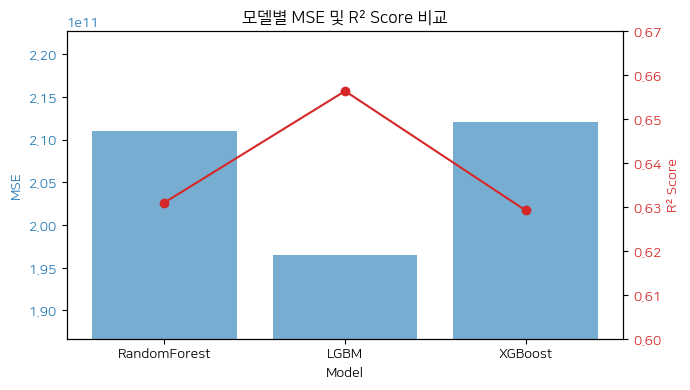

In [24]:
# 모델별 성능 데이터
models = ['RandomForest', 'LGBM', 'XGBoost']
mse = [211039179724.81, 196520764564.63, 212055064576.00]
r2 = [0.6310, 0.6564, 0.6292]

fig, ax1 = plt.subplots(figsize=(7, 4))

# MSE bar
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE', color=color)
ax1.bar(models, mse, color=color, alpha=0.6, label='MSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(mse)*0.95, max(mse)*1.05])

# R2 line
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R² Score', color=color)
ax2.plot(models, r2, color=color, marker='o', label='R²')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.6, 0.67])

plt.title('모델별 MSE 및 R² Score 비교')
fig.tight_layout()
plt.show()

### 모델별 성능 분석

| 모델           | MSE                | R² Score |
|----------------|--------------------|----------|
| RandomForest   | 211,039,179,724.81 | 0.6310   |
| LGBM           | 196,520,764,564.63 | 0.6564   |
| XGBoost        | 212,055,064,576.00 | 0.6292   |

- **LGBM**  
    - 가장 낮은 MSE(약 1,965억)와 가장 높은 R²(0.6564)로, 세 모델 중 예측 성능이 가장 우수함.
    - 데이터의 분포와 특성을 잘 반영하여, 실제값의 약 65.6%를 설명함.

- **RandomForest**  
    - MSE와 R² 모두 XGBoost보다 약간 더 우수하지만, LGBM보다는 성능이 낮음.
    - R²=0.6310으로, 예측력은 63% 수준.

- **XGBoost**  
    - MSE가 가장 높고(R²도 가장 낮음), 세 모델 중 상대적으로 예측력이 떨어짐.
    - 하지만 RandomForest와 큰 차이는 없음.

**요약:**  
세 모델 모두 비슷한 수준의 예측력을 보이나, LGBM이 가장 우수한 성능을 나타냄.  
트리 기반 모델 특성상 변수 중요도 해석이 용이하며, 대용량 데이터에서도 효율적으로 동작함.  
R²가 0.65 내외로, 입력 변수만으로 심결요양급여비용총액의 약 65%를 설명할 수 있음을 의미함.